# Customer Churn Prediction

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#### Data Preparation based on EDA

In [10]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
    
    return df

In [11]:
df = datapreparation(filepath = "C:/Users/ASUS/Documents/project/Telco-Customer-Churn.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


In [12]:
df.isnull().any().any()

False

## Model Building

I am going to build and tune random forest model because in this case tree based method would perform better. I am also interested in individual customer's churning probability and in understanding how the model calculates it using Shap values.

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [14]:
train, test = train_test_split(df, test_size=0.2, random_state=111, stratify = df.Churn)

In [15]:
x = df.columns[df.columns!="Churn"]
y = "Churn"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]

In [16]:
#function for model fitting
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]
    
    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()

In [37]:
model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                                       max_depth=1, n_estimators=100,
                                       n_jobs=-1, random_state=0).fit(train_x,train_y)

RandomForestClassifier(n_estimators=1, random_state=101)

 Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1035
           1       0.49      0.51      0.50       374

    accuracy                           0.73      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409

Accuracy   Score :  0.7288857345635202
Area under curve :  0.659580459324705 



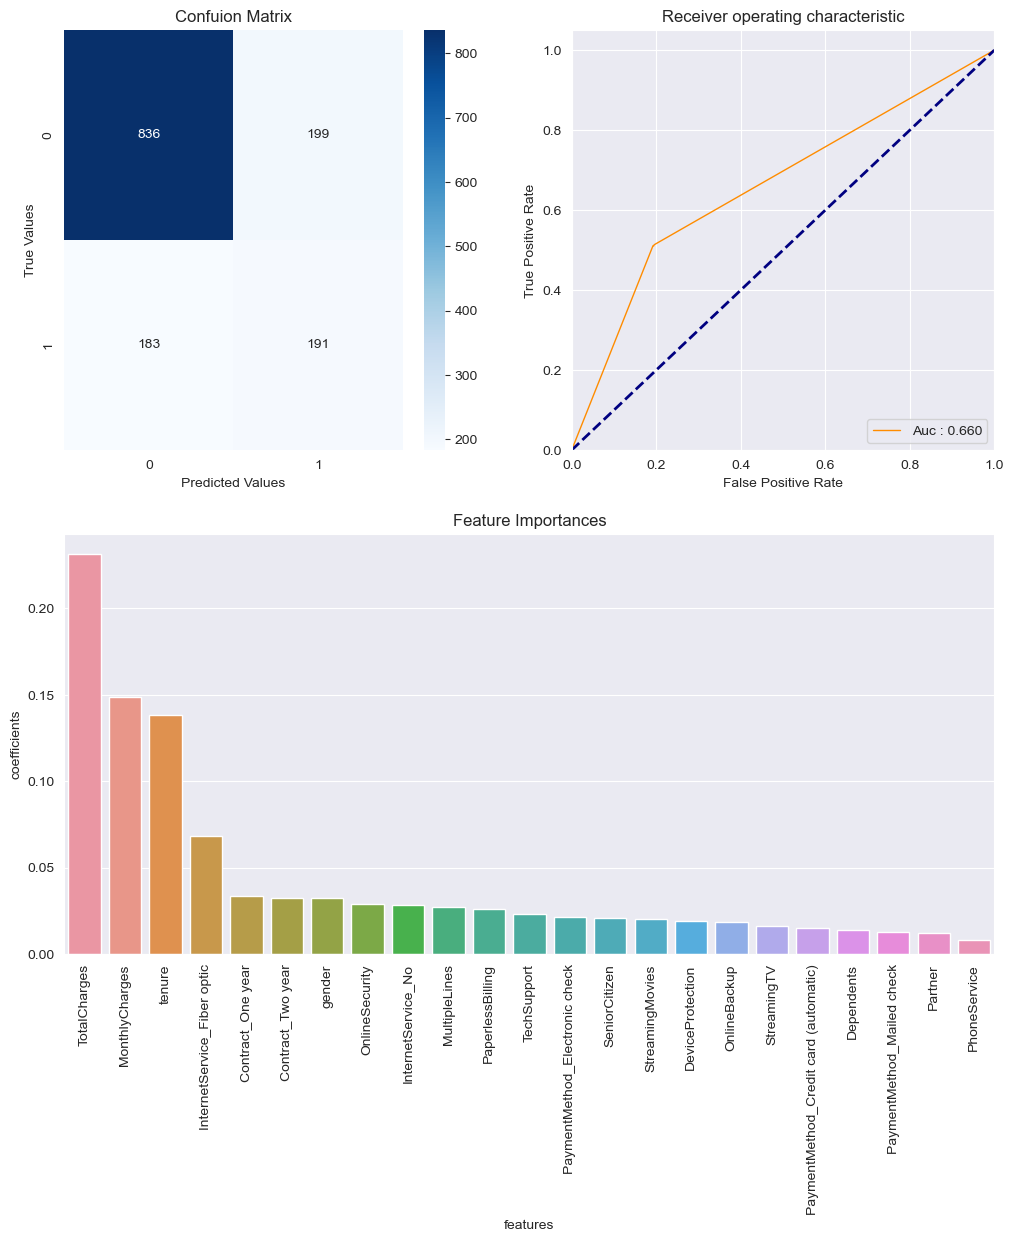

In [38]:
churn_prediction(model, train_x, train_y, test_x, test_y, x,"features")

Checking the model's performance on train data itself

In [39]:
train_scores = cross_val_score(model, train_x, train_y, cv = 5, scoring='f1')
train_scores

array([0.465625  , 0.50853242, 0.48231511, 0.45375218, 0.51973684])

In [40]:
np.mean(train_scores)

0.485992311870904

In [41]:
import numpy as np 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

clf = RandomForestClassifier(class_weight='balanced')
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter =10, 
                               cv = 5, verbose= 1, random_state= 101, n_jobs = -1)
model.fit(train_x,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [20]},
                   random_state=101, verbose=1)

<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

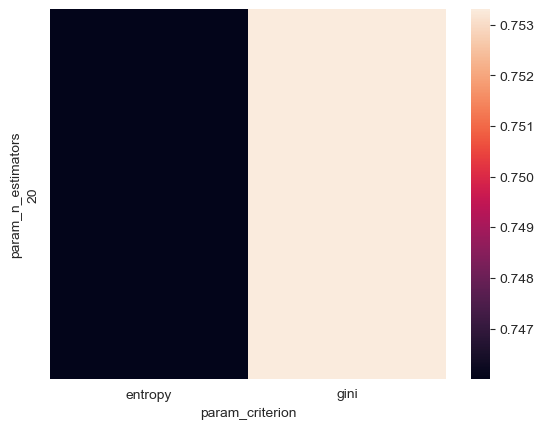

In [42]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [43]:
predictionforest = model.best_estimator_.predict(test_x)
print(confusion_matrix(test_y,predictionforest))
print(classification_report(test_y,predictionforest))
acc3 = accuracy_score(test_y,predictionforest)

[[1035    0]
 [ 374    0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
from sklearn.model_selection import GridSearchCV

grid_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

clf = RandomForestClassifier(random_state=101, class_weight='balanced')
model = GridSearchCV(estimator = clf, param_grid = grid_search, 
                               cv = 4, verbose= 5, n_jobs = -1)
model.fit(train_x,train_y)

predictionforest = model.best_estimator_.predict(test_x)
print(confusion_matrix(test_y,predictionforest))
print(classification_report(test_y,predictionforest))
acc4 = accuracy_score(test_y,predictionforest)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[[1009   26]
 [ 305   69]]
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1035
           1       0.73      0.18      0.29       374

    accuracy                           0.77      1409
   macro avg       0.75      0.58      0.58      1409
weighted avg       0.76      0.77      0.71      1409



In [45]:
!pip install hyperopt

In [46]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 12, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, train_x, train_y, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 20,
            trials= trials)
best

100%|███████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29trial/s, best loss: -0.7665965848603136]


{'criterion': 1,
 'max_depth': 10.0,
 'max_features': 2,
 'min_samples_leaf': 0.06933756648394096,
 'min_samples_split': 0.19154252855531972,
 'n_estimators': 0}

In [47]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 75, 3: 100, 4: 125}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(train_x,train_y)
predictionforest = trainedforest.predict(test_x)
print(confusion_matrix(test_y,predictionforest))
print(classification_report(test_y,predictionforest))
acc5 = accuracy_score(test_y,predictionforest)

[[1016   19]
 [ 304   70]]
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1035
           1       0.79      0.19      0.30       374

    accuracy                           0.77      1409
   macro avg       0.78      0.58      0.58      1409
weighted avg       0.77      0.77      0.71      1409



In [48]:
pip install deap update_checker tqdm stopit

In [49]:
pip install tpot

Note: you may need to restart the kernel to use updated packages.


In [50]:
from tpot import TPOTClassifier
from tpot import TPOTRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto'],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': [10]}

               
tpot_classifier = TPOTClassifier(generations= 10, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 30,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 4, scoring = 'accuracy')

tpot_classifier.fit(train_x,train_y) 

Optimization Progress:   0%|          | 0/144 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7870083100119363

Generation 2 - Current best internal CV score: 0.7921550634315117

Generation 3 - Current best internal CV score: 0.7921558195286793

Generation 4 - Current best internal CV score: 0.7921558195286793

Generation 5 - Current best internal CV score: 0.7942842330553584

Generation 6 - Current best internal CV score: 0.7942842330553584

Generation 7 - Current best internal CV score: 0.7942842330553584

Generation 8 - Current best internal CV score: 0.7942842330553584

Generation 9 - Current best internal CV score: 0.7942842330553584

Generation 10 - Current best internal CV score: 0.7942842330553584

Best pipeline: RandomForestClassifier(RandomForestClassifier(RandomForestClassifier(input_matrix, criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10), criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10), criterion=entro

TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [2],
                                                                        'max_features': ['auto'],
                                                                        'min_samples_leaf': [4,
                                                                                             12],
                                                                        'min_samples_split': [5,
                                                                                              10],
                                                                        'n_estimators': [10]}},
               cv=4, early_stop=30, generations=10, offspring_size=12,
               population_size=24, scoring='accuracy', verbosit

In [51]:
accuracy = tpot_classifier.score(test_x, test_y)
print(accuracy)

0.7963094393186657


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [52]:
prediction_test = tpot_classifier.predict(test_x)
print(confusion_matrix(test_y,prediction_test))
print(classification_report(test_y,prediction_test))
accuracy_ANN = accuracy_score(test_y,prediction_test)

[[940  95]
 [192 182]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.49      0.56       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.80      0.79      1409



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Optimization Progress:   0%|          | 0/144 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.794461537841151

Generation 2 - Current best internal CV score: 0.794461537841151

Generation 3 - Current best internal CV score: 0.794461537841151

Generation 4 - Current best internal CV score: 0.794461537841151

Generation 5 - Current best internal CV score: 0.794461537841151

Generation 6 - Current best internal CV score: 0.794461537841151

Generation 7 - Current best internal CV score: 0.794461537841151

Generation 8 - Current best internal CV score: 0.7951717651138783

Generation 9 - Current best internal CV score: 0.7951717651138783

Generation 10 - Current best internal CV score: 0.7951717651138783

Best pipeline: RandomForestClassifier(RandomForestClassifier(RandomForestClassifier(RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10), criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=4, min_sampl

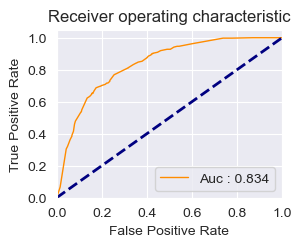

In [53]:
    tpot_classifier.fit(train_x,train_y)
    probabilities = tpot_classifier.predict_proba(test_x)[:,1]
    model_roc_auc = roc_auc_score(test_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(test_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

As we can see that the performance of the model on test data is same as training data. So, we can conclude that there is no overfitting and underfitting.

#### Saving model

In [56]:
import pickle
pickle.dump(tpot_classifier, open('tclassifier.pkl','wb'))